**1. Importing the dependencies**

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
# Tiền xử lý dữ liệu
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# Chia dữ liệu và đánh giá mô hình
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve

# Các thuật toán phân loại
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Các thuật toán hồi quy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# Đánh giá mô hình
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, precision_recall_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# Xử lý cảnh báo
import warnings
warnings.simplefilter(action="ignore")

# Lưu và tải mô hình
import pickle


In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 28. Model with Survival Analysis

In [ ]:
from google.colab import files
uploaded = files.upload()

train_df = pd.read_csv('train_survival.csv')
test_df = pd.read_csv('test_survival.csv')

# Tách các đặc trưng và giá trị churn từ các file
X_train = train_df.drop(columns=['churn_value'])
y_train = train_df['churn_value']

X_test = test_df.drop(columns=['churn_value'])
y_test = test_df['churn_value']

Saving Merged_Churn_Dataset.csv to Merged_Churn_Dataset.csv
Saving survival_features_test.csv to survival_features_test.csv
Saving survival_features_train.csv to survival_features_train.csv
Saving test_survival.csv to test_survival.csv
Saving train_survival.csv to train_survival.csv


In [ ]:
survival_train = pd.read_csv("survival_features_train.csv")
survival_test = pd.read_csv("survival_features_test.csv")

# Merge lại vào X_train, X_test bằng index (thứ tự hàng)
X_train_final = pd.concat([X_train.reset_index(drop=True), survival_train], axis=1)
X_test_final = pd.concat([X_test.reset_index(drop=True), survival_test], axis=1)


In [ ]:
X_train_final

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,hazard_group,survival_prob_3m,survival_prob_6m,survival_prob_12m
0,0,-0.150,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.975,-0.480,1.410,0.000,0.000,0.474,349,0.940,-0.369,0.679,-0.713,1,1,0.879,False,False,False,True,False,False,False,True,False,-5.730,11.271,Low,0.000,0.000,0.000
1,1,-0.150,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-1.509,-0.371,-0.913,0.000,0.000,-0.174,554,-1.860,0.870,-0.858,0.733,0,1,-1.473,False,False,False,False,False,False,True,True,False,-3.743,0.025,Medium-Low,0.965,0.950,0.907
2,0,-0.687,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.521,0.806,-0.946,0.000,0.000,-0.295,989,-0.011,-0.285,-0.268,-0.456,1,0,0.299,False,False,False,False,False,False,False,False,False,5.136,0.005,High,0.990,0.986,0.969
3,1,-0.687,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.332,1.676,0.076,0.000,0.000,1.080,368,-1.229,0.706,-0.835,0.701,1,1,0.057,False,True,False,False,False,True,False,True,False,-2.731,0.295,Medium-Low,0.661,0.529,0.267
4,0,0.387,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.706,1.603,-0.493,0.000,0.000,0.238,52,-0.033,-0.496,-0.409,-0.451,1,0,0.535,True,False,False,False,False,False,False,True,False,2.949,0.031,High,0.955,0.942,0.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.149,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-1.463,1.450,-0.807,0.000,0.000,0.532,952,-1.511,0.359,-0.970,0.818,0,1,-1.354,True,False,False,False,False,True,False,False,True,-4.871,0.079,Medium-Low,0.895,0.863,0.724
5630,0,-1.284,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.978,-1.043,0.841,0.000,0.000,-0.102,170,1.363,-0.513,1.994,-1.198,1,0,0.883,False,False,True,False,False,False,False,True,False,-0.868,0.981,Medium-High,0.267,0.141,0.009
5631,1,0.149,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.681,-1.398,-0.241,0.000,0.000,-0.334,290,-0.945,0.375,-0.858,0.794,1,0,0.503,True,False,False,False,False,False,False,False,False,2.621,0.060,High,0.918,0.885,0.774
5632,0,-0.269,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-1.331,-0.144,-0.754,0.000,0.000,0.086,363,1.373,-0.420,1.553,-1.123,0,0,-1.019,True,False,False,False,False,False,True,False,True,-6.454,0.098,Low,0.873,0.830,0.661


In [ ]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

# One-hot encoding cho cột 'hazard_group' bằng pd.get_dummies
X_train_final = pd.get_dummies(X_train_final, columns=['hazard_group'], drop_first=False)
X_test_final = pd.get_dummies(X_test_final, columns=['hazard_group'], drop_first=False)

# Sử dụng RobustScaler cho các cột số liệu
columns_to_scale = ['hazard_score', 'baseline_hazard', 'survival_prob_3m', 'survival_prob_6m', 'survival_prob_12m']

# Khởi tạo RobustScaler
scaler = RobustScaler()

# Chuẩn hóa các cột cho cả train và test
X_train_final[columns_to_scale] = scaler.fit_transform(X_train_final[columns_to_scale])
X_test_final[columns_to_scale] = scaler.transform(X_test_final[columns_to_scale])



In [ ]:
X_train_final.head()

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low
0,0,-0.150,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.975,-0.480,1.410,0.000,0.000,0.474,349,0.940,-0.369,0.679,-0.713,1,1,0.879,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.794,-0.716,-0.450,False,True,False,False
1,1,-0.150,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-1.509,-0.371,-0.913,0.000,0.000,-0.174,554,-1.860,0.870,-0.858,0.733,0,1,-1.473,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.195,0.269,0.520,False,False,False,True
2,0,-0.687,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.521,0.806,-0.946,0.000,0.000,-0.295,989,-0.011,-0.285,-0.268,-0.456,1,0,0.299,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.222,0.306,0.586,True,False,False,False
3,1,-0.687,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.332,1.676,0.076,0.000,0.000,1.080,368,-1.229,0.706,-0.835,0.701,1,1,0.057,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.116,-0.167,-0.164,False,False,False,True
4,0,0.387,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.706,1.603,-0.493,0.000,0.000,0.238,52,-0.033,-0.496,-0.409,-0.451,1,0,0.535,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.186,0.261,0.497,True,False,False,False


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd

# Chuyển đổi categorical sang numeric bằng one-hot encoding
X_train_encoded = pd.get_dummies(X_train_final, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_final, drop_first=True)

# Đảm bảo train và test có cùng số lượng cột
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Số cụm khách hàng
n_clusters = 4

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_final['kmeans_cluster'] = kmeans.fit_predict(X_train_encoded)
X_test_final['kmeans_cluster'] = kmeans.predict(X_test_encoded)

# CatBoost model
catboost_model = CatBoostClassifier(verbose=False, random_state=42)
catboost_model.fit(X_train_encoded, y_train)

# Optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(catboost_model, X_train_encoded, y_train)

# Đánh giá mô hình
y_proba_test = catboost_model.predict_proba(X_test_encoded)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Kết quả
print("\n📊 Final CatBoost Model (with K-Means) Performance")
print(classification_report(y_test, y_pred_test))
print(f"🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_test):.4f}")


📊 Final CatBoost Model (with K-Means) Performance
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1035
           1       0.70      0.74      0.72       374

    accuracy                           0.85      1409
   macro avg       0.80      0.81      0.81      1409
weighted avg       0.85      0.85      0.85      1409

🎯 Optimal Threshold: 0.3985
AUC Score: 0.9129


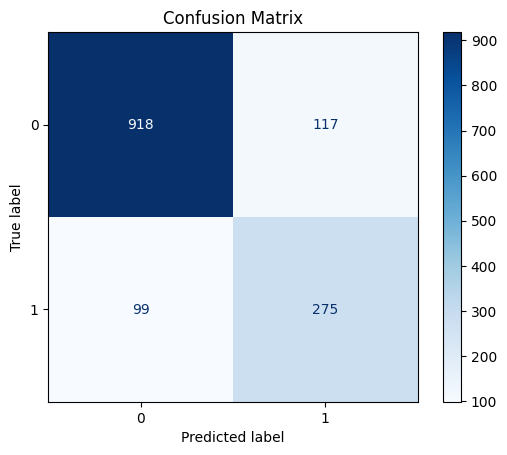

Final CatBoost Model Performance on Test Set
---------------------------------------------
Accuracy : 0.8467
Recall   : 0.7353
Precision: 0.7015
F1 Score : 0.7180
AUC      : 0.9129


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
print("Final CatBoost Model Performance on Test Set")
print("---------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")

In [ ]:
X_train_encoded

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low
0,0,-0.150,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.975,-0.480,1.410,0.000,0.000,0.474,349,0.940,-0.369,0.679,-0.713,1,1,0.879,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.794,-0.716,-0.450,False,True,False,False
1,1,-0.150,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-1.509,-0.371,-0.913,0.000,0.000,-0.174,554,-1.860,0.870,-0.858,0.733,0,1,-1.473,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.195,0.269,0.520,False,False,False,True
2,0,-0.687,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.521,0.806,-0.946,0.000,0.000,-0.295,989,-0.011,-0.285,-0.268,-0.456,1,0,0.299,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.222,0.306,0.586,True,False,False,False
3,1,-0.687,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.332,1.676,0.076,0.000,0.000,1.080,368,-1.229,0.706,-0.835,0.701,1,1,0.057,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.116,-0.167,-0.164,False,False,False,True
4,0,0.387,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.706,1.603,-0.493,0.000,0.000,0.238,52,-0.033,-0.496,-0.409,-0.451,1,0,0.535,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.186,0.261,0.497,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.149,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-1.463,1.450,-0.807,0.000,0.000,0.532,952,-1.511,0.359,-0.970,0.818,0,1,-1.354,True,False,False,False,False,True,False,False,True,-0.506,-0.016,0.124,0.179,0.324,False,False,False,True
5630,0,-1.284,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.978,-1.043,0.841,0.000,0.000,-0.102,170,1.363,-0.513,1.994,-1.198,1,0,0.883,False,False,True,False,False,False,False,True,False,0.011,0.155,-0.520,-0.569,-0.440,False,False,True,False
5631,1,0.149,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.681,-1.398,-0.241,0.000,0.000,-0.334,290,-0.945,0.375,-0.858,0.794,1,0,0.503,True,False,False,False,False,False,False,False,False,0.461,-0.020,0.148,0.202,0.378,True,False,False,False
5632,0,-0.269,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-1.331,-0.144,-0.754,0.000,0.000,0.086,363,1.373,-0.420,1.553,-1.123,0,0,-1.019,True,False,False,False,False,False,True,False,True,-0.710,-0.013,0.101,0.145,0.257,False,True,False,False


## 29. Hyper Tuning

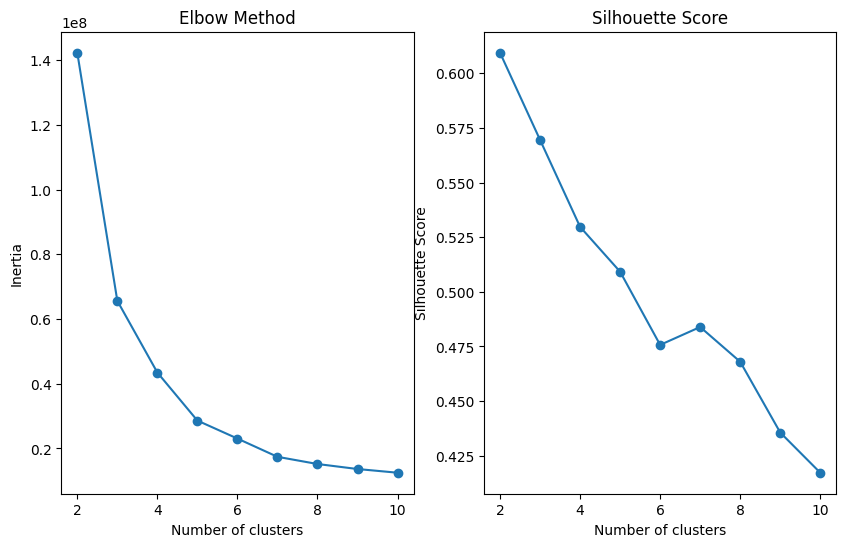

([142261649.87829036,
  65605622.91118072,
  43449032.532424085,
  28601975.63619118,
  23046498.762704898,
  17410449.78221644,
  15183976.928450186,
  13636944.974375503,
  12492444.795683803],
 [0.6094159786738924,
  0.5695384726784051,
  0.529751428718832,
  0.5092259924188745,
  0.4757323780731075,
  0.4839197728249783,
  0.46801774384742567,
  0.43564149651562356,
  0.4172468898565261])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, silhouette_score


X_train_encoded = pd.get_dummies(X_train_final, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_final, drop_first=True)

# Đảm bảo train và test có cùng số lượng cột
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Sử dụng Elbow Method để tìm số cụm tốt
def find_optimal_clusters(X_train):
    inertia = []
    silhouette_scores = []
    for n_clusters in range(2, 11):  # Kiểm tra từ 2 đến 10 cụm
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

    # Vẽ đồ thị Elbow Method
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    # Vẽ đồ thị Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')

    plt.show()

    return inertia, silhouette_scores

# Tìm số cụm tối ưu
find_optimal_clusters(X_train_encoded)

In [ ]:
n_clusters = 4

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_final['kmeans_cluster'] = kmeans.fit_predict(X_train_encoded)
X_test_final['kmeans_cluster'] = kmeans.predict(X_test_encoded)

# CatBoost model with selected hyperparameters
catboost_model = CatBoostClassifier(
    learning_rate=0.01,
    iterations=1000,
    depth=6,
    random_strength=0.1,
    bagging_temperature =0.2,
    l2_leaf_reg = 3,
    colsample_bylevel = 1.0,
    verbose=False,
    random_state=42
)

# Tiến hành training với model đã chọn tham số
catboost_model.fit(X_train_encoded, y_train)

# Tìm optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(catboost_model, X_train_encoded, y_train)

# Đánh giá mô hình
y_proba_test = catboost_model.predict_proba(X_test_encoded)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Kết quả
print("\n📊 Final CatBoost Model (with K-Means) Performance")
print(classification_report(y_test, y_pred_test))
print(f"🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_test):.4f}")


📊 Final CatBoost Model (with K-Means) Performance
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1035
           1       0.74      0.72      0.73       374

    accuracy                           0.86      1409
   macro avg       0.82      0.81      0.82      1409
weighted avg       0.86      0.86      0.86      1409

🎯 Optimal Threshold: 0.4439
AUC Score: 0.9128


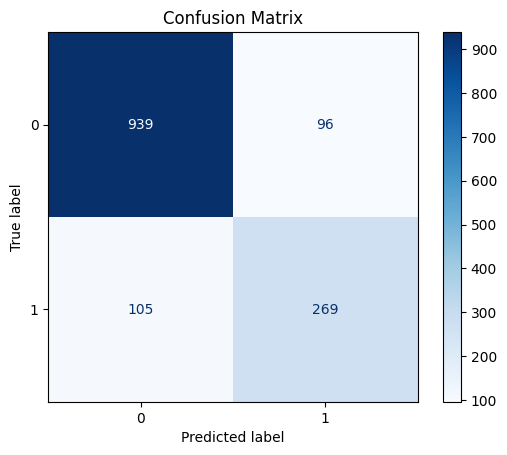

Final CatBoost Model Performance on Test Set
---------------------------------------------
Accuracy : 0.8573
Recall   : 0.7193
Precision: 0.7370
F1 Score : 0.7280
AUC      : 0.9128


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
print("Final CatBoost Model Performance on Test Set")
print("---------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")

In [ ]:
def plot_importance(model, features, num=len(X_train_final), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)  # Điều chỉnh kích thước font chữ

    # Vẽ biểu đồ thanh
    ax = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

    plt.title(f'Feature Importance - {model.__class__.__name__}')

    # Tăng khoảng cách giữa các nhãn bằng cách điều chỉnh khoảng cách trên trục y
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Tăng kích thước font chữ của nhãn y
    ax.set_yticks(range(len(feature_imp)))  # Đảm bảo các tick trên trục y cách nhau đồng đều

    plt.tight_layout()
    plt.show(block=True)

    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

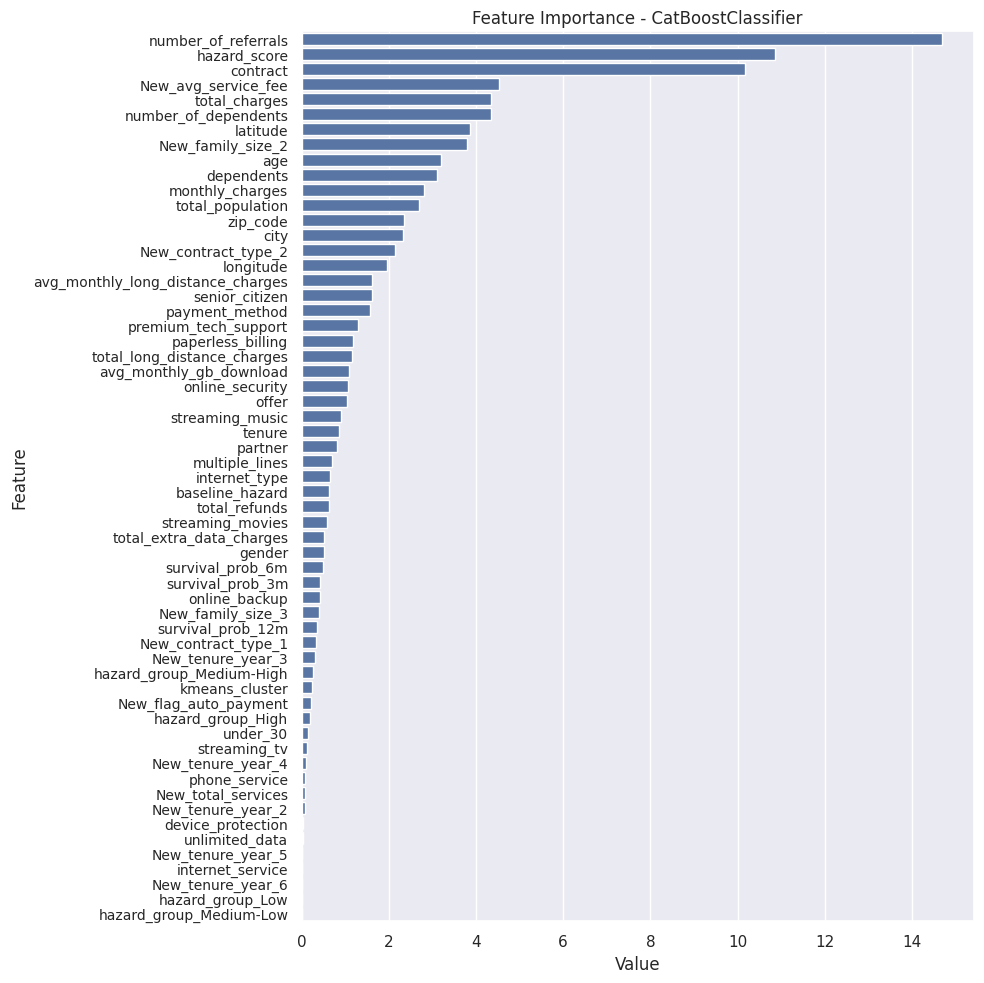

In [ ]:
plot_importance(catboost_model, X_train_final)

In [ ]:
X_train_encoded

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low,kmeans_cluster
0,0,-0.150,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.975,-0.480,1.410,0.000,0.000,0.474,349,0.940,-0.369,0.679,-0.713,1,1,0.879,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.794,-0.716,-0.450,False,True,False,False,2
1,1,-0.150,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-1.509,-0.371,-0.913,0.000,0.000,-0.174,554,-1.860,0.870,-0.858,0.733,0,1,-1.473,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.195,0.269,0.520,False,False,False,True,0
2,0,-0.687,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.521,0.806,-0.946,0.000,0.000,-0.295,989,-0.011,-0.285,-0.268,-0.456,1,0,0.299,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.222,0.306,0.586,True,False,False,False,1
3,1,-0.687,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.332,1.676,0.076,0.000,0.000,1.080,368,-1.229,0.706,-0.835,0.701,1,1,0.057,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.116,-0.167,-0.164,False,False,False,True,2
4,0,0.387,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.706,1.603,-0.493,0.000,0.000,0.238,52,-0.033,-0.496,-0.409,-0.451,1,0,0.535,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.186,0.261,0.497,True,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.149,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-1.463,1.450,-0.807,0.000,0.000,0.532,952,-1.511,0.359,-0.970,0.818,0,1,-1.354,True,False,False,False,False,True,False,False,True,-0.506,-0.016,0.124,0.179,0.324,False,False,False,True,1
5630,0,-1.284,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.978,-1.043,0.841,0.000,0.000,-0.102,170,1.363,-0.513,1.994,-1.198,1,0,0.883,False,False,True,False,False,False,False,True,False,0.011,0.155,-0.520,-0.569,-0.440,False,False,True,False,3
5631,1,0.149,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.681,-1.398,-0.241,0.000,0.000,-0.334,290,-0.945,0.375,-0.858,0.794,1,0,0.503,True,False,False,False,False,False,False,False,False,0.461,-0.020,0.148,0.202,0.378,True,False,False,False,2
5632,0,-0.269,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-1.331,-0.144,-0.754,0.000,0.000,0.086,363,1.373,-0.420,1.553,-1.123,0,0,-1.019,True,False,False,False,False,False,True,False,True,-0.710,-0.013,0.101,0.145,0.257,False,True,False,False,2


## 30. Accelerated Failure Time in Training set

In [ ]:
from google.colab import files
uploaded = files.upload()

merged_churn_data = pd.read_csv('Merged_Churn_Dataset.csv')

In [ ]:
merged_churn_data

,customer_id,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason,country,state,city,zip_code,total_population,latitude,longitude
0,0002-ORFBO,Female,37,No,No,Yes,No,0,Yes,9,Yes,Yes,No,16,Yes,NaN,Yes,2,No,Yes,No,Yes,Yes,No,No,Cable,One Year,Yes,Mailed check,65.600,42.390,593.300,0.000,0,381.510,974.810,3,2205,Stayed,65,No,0,Not Applicable,NaN,United States,California,Frazier Park,93225,4498,34.828,-118.999
1,0003-MKNFE,Male,46,No,No,No,No,0,No,9,Yes,Yes,Yes,10,No,NaN,No,0,No,No,No,No,No,Yes,Yes,Cable,Month-to-Month,No,Mailed check,59.900,10.690,542.400,38.330,10,96.210,610.280,5,5414,Stayed,66,No,0,Not Applicable,NaN,United States,California,Glendale,91206,31297,34.163,-118.204
2,0004-TLHLJ,Male,50,No,No,No,No,0,No,4,Yes,Yes,No,30,Yes,Offer E,No,0,No,No,Yes,No,No,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,73.900,33.650,280.850,0.000,0,134.600,415.450,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices,United States,California,Costa Mesa,92627,62069,33.646,-117.923
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,Yes,13,Yes,Yes,No,4,Yes,Offer D,Yes,1,No,Yes,Yes,No,Yes,Yes,No,Fiber Optic,Month-to-Month,Yes,Electronic check,98.000,27.820,1237.850,0.000,0,361.660,1599.510,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction,United States,California,Martinez,94553,46677,38.014,-122.115
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,Yes,3,Yes,Yes,No,11,Yes,NaN,Yes,3,No,No,No,Yes,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Mailed check,83.900,7.380,267.400,0.000,0,22.140,289.540,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability,United States,California,Camarillo,93010,42853,34.228,-119.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,Yes,No,No,No,0,No,13,Yes,Yes,No,59,Yes,Offer D,No,0,Yes,No,No,Yes,No,No,Yes,DSL,One Year,No,Mailed check,55.150,46.680,742.900,0.000,0,606.840,1349.740,4,3161,Stayed,59,No,0,Not Applicable,NaN,United States,California,La Mesa,91941,44652,32.759,-116.997
7039,9992-RRAMN,Male,40,No,No,Yes,No,0,Yes,22,Yes,Yes,Yes,17,Yes,Offer D,Yes,1,No,No,No,No,No,Yes,Yes,Fiber Optic,Month-to-Month,Yes,Electronic check,85.100,16.200,1873.700,0.000,0,356.400,2230.100,1,5248,Churned,68,Yes,1,Dissatisfaction,Product dissatisfaction,United States,California,Riverbank,95367,16525,37.735,-120.954
7040,9992-UJOEL,Male,22,Yes,No,No,No,0,No,2,Yes,Yes,No,51,Yes,Offer E,No,0,No,Yes,No,No,No,No,No,DSL,Month-to-Month,Yes,Mailed check,50.300,18.620,92.750,0.000,0,37.240,129.990,5,5870,Joined,33,No,0,Not Applicable,NaN,United States,California,Elk,95432,383,39.108,-123.645
7041,9993-LHIEB,Male,21,Yes,No,Yes,No,0,Yes,67,Yes,Yes,No,58,Yes,Offer A,Yes,5,Yes,No,Yes,Yes,No,Yes,Yes,Cable,Two Year,No,Mailed check,67.850,2.120,4627.650,0.000,0,142.040,4769.690,3,4792,Stayed,59,No,0,Not Applicable,NaN,United States,California,Solana Beach,92075,12173,33.002,-117.264


In [ ]:
customer_ids = merged_churn_data['customer_id']

In [ ]:
X = merged_churn_data.drop(columns=['churn_value', 'customer_id'])  # Chọn tất cả các cột đặc trưng (trừ 'churn_value' và 'customer_id')
y = merged_churn_data['churn_value']  # Chọn cột 'churn_value' làm nhãn

# **Bước 2: Chia tập dữ liệu thành Train và Test (test_size=0.2)**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **Bước 3: Lấy customer_id từ merged_churn_data**
# Dùng chỉ số từ X_train và X_test để lấy `customer_id` từ merged_churn_data
customer_ids_train = merged_churn_data.loc[X_train.index, 'customer_id']
customer_ids_test = merged_churn_data.loc[X_test.index, 'customer_id']

In [ ]:
customer_ids_train.head()

,customer_id
3793,5334-JLAXU
3192,4573-JKNAE
4922,6923-JHPMP
3926,5524-KHNJP
3859,5433-KYGHE


In [ ]:
X_train['label_lower_bound'] = X_train['tenure']  # Sử dụng giá trị 'tenure' cho label_lower_bound

# Nếu churn_value == 0 (right-censored), thì label_upper_bound = Inf
X_train['label_upper_bound'] = X_train['tenure'].where(y_train == 0, float('inf'))  # Right-censored (churn = 0)

# Cập nhật lại label_upper_bound cho đúng
max_tenure = X_train['tenure'].max()  # Lấy giá trị lớn nhất trong 'tenure'
X_train['label_upper_bound'] = X_train['tenure'].where(y_train == 1, max_tenure)  # Cập nhật cho dữ liệu right-censored

X_train['label_upper_bound'] = X_train['label_upper_bound'].where(X_train['label_lower_bound'] != X_train['label_upper_bound'], 0.0000001)

In [ ]:
X_train

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_category,churn_reason,country,state,city,zip_code,total_population,latitude,longitude,label_lower_bound,label_upper_bound,churned
3793,Female,44,No,No,Yes,No,0,Yes,60,Yes,Yes,Yes,19,Yes,Offer B,Yes,8,Yes,Yes,No,No,No,Yes,Yes,Fiber Optic,Month-to-Month,Yes,Credit card (automatic),94.100,15.540,5475.900,0.000,0,932.400,6408.300,3,5267,Stayed,62,No,Not Applicable,NaN,United States,California,French Camp,95231,5094,37.873,-121.292,60,72.000,0
3192,Male,44,No,No,No,Yes,3,No,12,No,Yes,No,0,No,Offer D,No,0,No,No,No,No,No,No,No,NaN,Two Year,No,Bank transfer (automatic),19.350,17.230,212.300,0.000,0,206.760,419.060,5,2558,Stayed,74,No,Not Applicable,NaN,United States,California,Los Angeles,90032,46960,34.079,-118.178,12,72.000,0
4922,Female,35,No,No,No,No,0,No,2,Yes,Yes,No,25,Yes,NaN,No,0,Yes,No,Yes,No,No,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,80.450,35.410,137.100,0.000,0,70.820,207.920,4,5602,Joined,67,No,Not Applicable,NaN,United States,California,Templeton,93465,7918,35.536,-120.739,2,72.000,0
3926,Male,35,No,No,Yes,No,0,Yes,33,Yes,Yes,No,30,Yes,Offer C,Yes,7,Yes,No,Yes,No,Yes,Yes,Yes,Cable,One Year,No,Credit card (automatic),74.750,48.850,2453.300,0.000,0,1612.050,4065.350,3,5344,Stayed,26,No,Not Applicable,NaN,United States,California,Glendale,91205,41390,34.137,-118.246,33,72.000,0
3859,Female,53,No,No,No,Yes,1,No,14,Yes,Yes,Yes,22,Yes,Offer D,No,0,Yes,No,No,Yes,No,No,No,Fiber Optic,Month-to-Month,Yes,Mailed check,86.000,47.720,1164.050,0.000,0,668.080,1832.130,3,5494,Stayed,33,No,Not Applicable,NaN,United States,California,Avila Beach,93424,812,35.187,-120.728,14,72.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,Female,49,No,No,Yes,Yes,2,Yes,22,No,Yes,No,0,No,NaN,Yes,8,No,No,No,No,No,No,No,NaN,One Year,No,Bank transfer (automatic),20.750,45.350,452.350,0.000,0,997.700,1450.050,4,2258,Stayed,59,No,Not Applicable,NaN,United States,California,Stanton,90680,29694,33.802,-117.995,22,72.000,0
6146,Female,25,Yes,No,Yes,No,0,Yes,42,Yes,Yes,Yes,27,Yes,NaN,Yes,1,No,No,No,No,Yes,Yes,Yes,Fiber Optic,Month-to-Month,Yes,Electronic check,94.200,6.840,4186.300,0.000,0,287.280,4473.580,1,5458,Churned,95,Yes,Competitor,Competitor had better devices,United States,California,Castella,96017,228,41.121,-122.337,42,0.000,1
4485,Male,49,No,No,No,No,0,No,20,Yes,Yes,Yes,25,Yes,Offer D,No,0,No,No,No,No,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,85.250,1.360,1734.500,0.000,0,27.200,1761.700,2,2414,Churned,92,Yes,Other,Moved,United States,California,El Monte,91731,30211,34.080,-118.047,20,0.000,1
2739,Female,42,No,No,Yes,Yes,3,Yes,24,No,Yes,Yes,0,No,NaN,Yes,7,No,No,No,No,No,No,No,NaN,Two Year,No,Mailed check,24.700,20.740,571.750,0.000,0,497.760,1069.510,3,5302,Stayed,56,No,Not Applicable,NaN,United States,California,Gerber,96035,3357,40.032,-122.176,24,72.000,0


In [ ]:
print(X_train[['label_lower_bound', 'label_upper_bound']].head(30))

      label_lower_bound  label_upper_bound
3793                 60             72.000
3192                 12             72.000
4922                  2             72.000
3926                 33             72.000
3859                 14             72.000
2695                 72              0.000
2669                 30             72.000
188                   5             72.000
5804                 69             72.000
2284                 58             72.000
2666                 21             72.000
6958                 21             72.000
3999                 53             72.000
2794                 72              0.000
3154                 54             72.000
3028                 20             72.000
5482                 60             72.000
331                  25             72.000
10                   54             72.000
4617                 15             72.000
6297                 21             72.000
6263                 10             72.000
3796       

In [ ]:
#  Huấn luyện mô hình AFT với XGBoost**
params = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.20,
    "tree_method": "hist",
    "learning_rate": 0.05,
    "max_depth": 4
}

# Dự đoán thời gian churn cho tất cả khách hàng trong tập huấn luyện
dtrain = xgb.DMatrix(X_train_encoded)  # Tạo DMatrix từ X_train_encoded
dtrain.set_float_info('label_lower_bound', X_train['label_lower_bound'])
dtrain.set_float_info('label_upper_bound', X_train['label_upper_bound'])

# Huấn luyện mô hình
aft_model = xgb.train(params, dtrain, num_boost_round=200)

# Lưu mô hình AFT
with open("aft_model.pkl", "wb") as f:
    pickle.dump(aft_model, f)

# Lấy customer_id từ merged_churn_data**
customer_ids_train = merged_churn_data.loc[X_train.index, 'customer_id']

# Dự đoán thời gian churn cho tất cả khách hàng trong tập huấn luyện**
dtrain = xgb.DMatrix(X_train_encoded)  # Tạo DMatrix từ X_train_encoded
predicted_time_to_churn = aft_model.predict(dtrain)

# In ra kết quả dự đoán cho các khách hàng trong tập huấn luyện**
for i, pred in enumerate(predicted_time_to_churn[:30]):
    customer_id = customer_ids_train.iloc[i]  # Lấy customer_id từ merged_churn_data
    print(f"Khách hàng {customer_id} sẽ churn sau khoảng {pred:.2f} tháng.")

Khách hàng 5334-JLAXU sẽ churn sau khoảng 58.59 tháng.
Khách hàng 4573-JKNAE sẽ churn sau khoảng 29.65 tháng.
Khách hàng 6923-JHPMP sẽ churn sau khoảng 2.29 tháng.
Khách hàng 5524-KHNJP sẽ churn sau khoảng 50.82 tháng.
Khách hàng 5433-KYGHE sẽ churn sau khoảng 18.39 tháng.
Khách hàng 3831-YCPUO sẽ churn sau khoảng 2.03 tháng.
Khách hàng 3794-NFNCH sẽ churn sau khoảng 45.22 tháng.
Khách hàng 0303-WMMRN sẽ churn sau khoảng 13.48 tháng.
Khách hàng 8169-SAEJD sẽ churn sau khoảng 64.58 tháng.
Khách hàng 3259-QMXUN sẽ churn sau khoảng 64.09 tháng.
Khách hàng 3787-TRIAL sẽ churn sau khoảng 24.73 tháng.
Khách hàng 9867-XOBQA sẽ churn sau khoảng 45.43 tháng.
Khách hàng 5642-MHDQT sẽ churn sau khoảng 57.58 tháng.
Khách hàng 3976-HXHCE sẽ churn sau khoảng 2.36 tháng.
Khách hàng 4525-VZCZG sẽ churn sau khoảng 56.59 tháng.
Khách hàng 4329-YPDDQ sẽ churn sau khoảng 19.76 tháng.
Khách hàng 7717-BICXI sẽ churn sau khoảng 68.13 tháng.
Khách hàng 0487-VVUVK sẽ churn sau khoảng 42.79 tháng.
Khách hàng 00

#### Nếu lower_bound = upper_bound

In [ ]:
for i, pred in enumerate(predicted_time_to_churn[:30]):
    customer_id = customer_ids_train.iloc[i]
    # Kiểm tra nếu label_upper_bound == label_lower_bound
    if X_train['label_upper_bound'].iloc[i] == 0.0000001:
        print(f"Khách hàng {customer_id} đã churn ngay lập tức sau 0 tháng.")
    else:
        print(f"Khách hàng {customer_id} sẽ churn sau khoảng {pred:.2f} tháng.")

Khách hàng 5334-JLAXU sẽ churn sau khoảng 58.59 tháng.
Khách hàng 4573-JKNAE sẽ churn sau khoảng 29.65 tháng.
Khách hàng 6923-JHPMP sẽ churn sau khoảng 2.29 tháng.
Khách hàng 5524-KHNJP sẽ churn sau khoảng 50.82 tháng.
Khách hàng 5433-KYGHE sẽ churn sau khoảng 18.39 tháng.
Khách hàng 3831-YCPUO đã churn ngay lập tức sau 0 tháng.
Khách hàng 3794-NFNCH sẽ churn sau khoảng 45.22 tháng.
Khách hàng 0303-WMMRN sẽ churn sau khoảng 13.48 tháng.
Khách hàng 8169-SAEJD sẽ churn sau khoảng 64.58 tháng.
Khách hàng 3259-QMXUN sẽ churn sau khoảng 64.09 tháng.
Khách hàng 3787-TRIAL sẽ churn sau khoảng 24.73 tháng.
Khách hàng 9867-XOBQA sẽ churn sau khoảng 45.43 tháng.
Khách hàng 5642-MHDQT sẽ churn sau khoảng 57.58 tháng.
Khách hàng 3976-HXHCE đã churn ngay lập tức sau 0 tháng.
Khách hàng 4525-VZCZG sẽ churn sau khoảng 56.59 tháng.
Khách hàng 4329-YPDDQ sẽ churn sau khoảng 19.76 tháng.
Khách hàng 7717-BICXI sẽ churn sau khoảng 68.13 tháng.
Khách hàng 0487-VVUVK sẽ churn sau khoảng 42.79 tháng.
Khách h

## 31. Accelerated Failure Time in Testing set

In [ ]:
X_test_encoded

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low,kmeans_cluster
0,0,-1.583,1,0,1,0,0.000,21,1,0,0,1.750,1,4,2.667,1,0,0,0,0,0,0,1,0,0,2,-1.205,-1.486,-0.729,0.000,0.000,-0.358,893,1.034,0.139,0.908,-1.352,0,0,-0.696,True,False,False,False,False,False,False,True,False,0.059,-0.019,0.136,0.189,0.346,False,False,True,False,1
1,1,1.701,0,1,0,0,0.000,11,1,1,1,-0.167,0,0,0.000,0,1,1,1,1,1,0,2,2,1,2,1.550,-1.316,-0.484,0.000,40.000,-0.332,385,1.374,-0.511,2.159,-1.485,1,0,1.613,False,False,False,False,False,False,True,False,False,0.212,-0.027,0.200,0.275,0.532,False,False,True,False,2
2,1,1.820,0,1,0,0,0.000,4,1,1,0,0.333,1,0,0.000,0,0,0,0,0,0,0,2,2,0,2,0.152,0.463,-0.891,0.000,0.000,-0.251,339,1.371,-0.515,2.039,-1.596,1,0,-0.172,False,False,False,False,False,False,True,False,False,0.207,-0.030,0.219,0.301,0.577,False,False,True,False,2
3,1,-0.926,0,0,0,0,0.000,5,0,1,0,-0.708,0,0,0.000,0,0,0,0,0,0,0,3,0,0,3,-1.489,0.078,-0.959,0.000,0.000,-0.250,312,1.154,0.687,0.994,-0.695,0,0,-1.422,False,False,False,False,False,False,False,False,False,0.286,-0.030,0.217,0.299,0.572,False,False,True,False,2
4,1,-0.866,0,0,1,1,1.000,72,1,0,0,-0.042,0,0,0.333,1,1,1,1,1,1,1,1,2,1,0,0.030,-1.486,1.052,0.000,60.000,-0.358,554,-1.856,-0.229,-0.892,0.746,0,1,2.458,False,False,False,False,True,False,True,False,True,-1.138,25.351,-0.794,-0.716,-0.450,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,-0.687,0,0,0,0,0.000,1,0,1,0,-0.708,0,0,0.000,0,0,0,0,0,0,0,3,0,0,3,-1.516,-0.038,-0.998,0.000,0.000,-0.338,220,-0.737,0.194,-1.422,1.193,0,0,-1.490,False,False,False,False,False,False,False,False,False,0.297,-0.031,0.223,0.308,0.590,False,False,True,False,3
1405,0,0.089,0,0,0,0,0.000,3,1,1,0,-0.500,0,0,0.000,0,0,0,0,1,0,0,2,0,1,2,0.523,0.253,-0.904,0.000,0.000,-0.286,858,-0.921,0.606,-0.854,0.771,1,0,0.301,False,False,False,False,False,False,False,False,False,0.774,-0.030,0.220,0.304,0.582,True,False,False,False,1
1406,1,-1.523,1,0,0,0,0.000,1,1,1,0,2.167,0,0,0.000,0,0,0,0,0,1,1,1,0,1,2,-0.316,1.051,-0.982,0.000,60.000,-0.323,147,1.362,-0.507,2.143,-0.537,1,0,-0.770,False,False,False,False,False,False,False,False,False,0.628,-0.031,0.223,0.308,0.590,True,False,False,False,3
1407,1,0.626,0,0,1,1,1.000,24,1,1,1,-0.292,1,0,3.000,1,0,0,0,1,1,1,0,1,0,3,0.334,-0.925,-0.203,0.000,0.000,-0.173,198,1.411,-0.517,1.437,-0.383,1,0,0.059,True,False,False,False,False,True,False,False,True,-0.351,-0.013,0.101,0.145,0.257,False,False,False,True,3


In [ ]:
X_test['label_lower_bound'] = X_test['tenure']  # Dùng 'tenure' cho label_lower_bound

# Nếu churn_value == 0 (right-censored), thì label_upper_bound = Inf
X_test['label_upper_bound'] = X_test['tenure'].where(y_pred_test == 0, float('inf'))  # Right-censored (churn = 0)

# Cập nhật lại label_upper_bound cho đúng
max_tenure = X_test['tenure'].max()  # Lấy giá trị lớn nhất trong 'tenure'
X_test['label_upper_bound'] = X_test['tenure'].where(y_pred_test == 1, max_tenure)  # Cập nhật cho dữ liệu right-censored

X_test['label_upper_bound'] = X_test['label_upper_bound'].where(X_test['label_lower_bound'] != X_test['label_upper_bound'], 0.0000001)

In [ ]:
X_test

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_category,churn_reason,country,state,city,zip_code,total_population,latitude,longitude,label_lower_bound,label_upper_bound
455,Female,20,Yes,No,Yes,No,0,Yes,21,Yes,No,No,59,Yes,Offer D,Yes,8,Yes,No,No,No,No,No,No,DSL,Month-to-Month,No,Electronic check,28.500,0.000,629.350,0.000,0,0.000,629.350,4,3766,Stayed,77,No,Not Applicable,NaN,United States,California,Santa Rosa,95405,22250,38.440,-122.669,21,72.000
2301,Male,75,No,Yes,No,No,0,No,11,Yes,Yes,Yes,13,No,NaN,No,0,No,Yes,Yes,Yes,Yes,Yes,No,Fiber Optic,Two Year,Yes,Electronic check,111.400,2.630,1183.050,0.000,40,28.930,1251.980,3,3175,Stayed,28,No,Not Applicable,NaN,United States,California,Greenview,96037,295,41.529,-122.955,11,72.000
2255,Male,77,No,Yes,No,No,0,No,4,Yes,Yes,No,25,Yes,NaN,No,0,No,No,No,No,No,No,No,Fiber Optic,Two Year,No,Electronic check,69.350,30.110,261.650,0.000,0,120.440,382.090,3,4140,Stayed,26,No,Not Applicable,NaN,United States,California,Forks Of Salmon,96031,170,41.232,-123.195,4,72.000
4527,Male,31,No,No,No,No,0,No,5,No,Yes,No,0,No,NaN,No,0,No,No,No,No,No,No,No,NaN,Month-to-Month,No,Mailed check,19.950,24.160,107.050,0.000,0,120.800,227.850,5,4281,Stayed,20,No,Not Applicable,NaN,United States,California,Fair Oaks,95628,40750,38.652,-121.254,5,72.000
3812,Male,32,No,No,Yes,Yes,1,Yes,72,Yes,No,No,16,No,NaN,Yes,1,Yes,Yes,Yes,Yes,Yes,Yes,Yes,DSL,Two Year,Yes,Bank transfer (automatic),65.650,0.000,4664.500,0.000,60,0.000,4724.500,3,4934,Stayed,47,No,Not Applicable,NaN,United States,California,Los Angeles,90040,9805,33.995,-118.150,72,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,Female,35,No,No,No,No,0,No,1,No,Yes,No,0,No,NaN,No,0,No,No,No,No,No,No,No,NaN,Month-to-Month,No,Mailed check,19.150,22.370,19.150,0.000,0,22.370,41.520,5,2577,Joined,51,No,Not Applicable,NaN,United States,California,Coronado,92118,24093,32.687,-117.187,1,72.000
4510,Female,48,No,No,No,No,0,No,3,Yes,Yes,No,5,No,NaN,No,0,No,No,No,No,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,80.500,26.860,232.350,0.000,0,80.580,312.930,5,2032,Joined,53,No,Not Applicable,NaN,United States,California,San Gabriel,91776,38041,34.090,-118.096,3,0.000
3910,Male,21,Yes,No,No,No,0,No,1,Yes,Yes,No,69,No,NaN,No,0,No,No,No,No,No,Yes,Yes,DSL,Month-to-Month,Yes,Electronic check,55.250,39.190,55.250,0.000,60,39.190,154.440,5,3255,Joined,49,No,Not Applicable,NaN,United States,California,Canby,96015,417,41.487,-120.914,1,0.000
4820,Male,57,No,No,Yes,Yes,1,Yes,24,Yes,Yes,Yes,10,Yes,NaN,Yes,9,Yes,No,No,No,Yes,Yes,Yes,Cable,One Year,No,Mailed check,74.800,8.670,1821.200,0.000,0,208.080,2029.280,4,5535,Stayed,52,No,Not Applicable,NaN,United States,California,Clio,96106,88,39.746,-120.581,24,72.000


In [ ]:
print(X_test[['label_lower_bound', 'label_upper_bound']].head(10))

      label_lower_bound  label_upper_bound
455                  21             72.000
2301                 11             72.000
2255                  4             72.000
4527                  5             72.000
3812                 72              0.000
5784                 71             72.000
3635                 67             72.000
3013                 70             72.000
5962                 26             72.000
1628                  5              0.000


In [ ]:
dtest = xgb.DMatrix(X_test_encoded)  # Tạo DMatrix từ X_test
dtest.set_float_info('label_lower_bound', X_test['label_lower_bound'])
dtest.set_float_info('label_upper_bound', X_test['label_upper_bound'])

# **Dự đoán thời gian churn cho các khách hàng trong tập test**
# Sử dụng mô hình AFT đã huấn luyện từ bước trước
with open("aft_model.pkl", "rb") as f:
    aft_model = pickle.load(f)

# Dự đoán thời gian churn
predicted_time_to_churn = aft_model.predict(dtest)

# **In ra kết quả dự đoán cho các khách hàng trong tập test**
for i, pred in enumerate(predicted_time_to_churn[:10]):
    customer_id = customer_ids_test.iloc[i]
    print(f"Khách hàng {customer_id} sẽ churn sau khoảng {pred:.2f} tháng.")

Khách hàng 0668-OGMHD sẽ churn sau khoảng 39.64 tháng.
Khách hàng 3292-PBZEJ sẽ churn sau khoảng 20.42 tháng.
Khách hàng 3223-DWFIO sẽ churn sau khoảng 11.42 tháng.
Khách hàng 6377-KSLXC sẽ churn sau khoảng 14.70 tháng.
Khách hàng 5360-XGYAZ sẽ churn sau khoảng 1.99 tháng.
Khách hàng 8146-QQKZH sẽ churn sau khoảng 75.07 tháng.
Khách hàng 5146-YYFRZ sẽ churn sau khoảng 65.85 tháng.
Khách hàng 4312-GVYNH sẽ churn sau khoảng 62.44 tháng.
Khách hàng 8404-FYDIB sẽ churn sau khoảng 24.57 tháng.
Khách hàng 2369-UAPKZ sẽ churn sau khoảng 1.19 tháng.


In [ ]:
y_pred_test[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
for i, pred in enumerate(predicted_time_to_churn[:10]):
    customer_id = customer_ids_test.iloc[i]
    # Kiểm tra nếu label_upper_bound == label_lower_bound
    if X_test['label_upper_bound'].iloc[i] == 0.0000001:
        print(f"Khách hàng {customer_id} đã churn ngay lập tức sau 0 tháng.")
    else:
        print(f"Khách hàng {customer_id} sẽ churn sau khoảng {pred:.2f} tháng.")

Khách hàng 0668-OGMHD sẽ churn sau khoảng 39.64 tháng.
Khách hàng 3292-PBZEJ sẽ churn sau khoảng 20.42 tháng.
Khách hàng 3223-DWFIO sẽ churn sau khoảng 11.42 tháng.
Khách hàng 6377-KSLXC sẽ churn sau khoảng 14.70 tháng.
Khách hàng 5360-XGYAZ đã churn ngay lập tức sau 0 tháng.
Khách hàng 8146-QQKZH sẽ churn sau khoảng 75.07 tháng.
Khách hàng 5146-YYFRZ sẽ churn sau khoảng 65.85 tháng.
Khách hàng 4312-GVYNH sẽ churn sau khoảng 62.44 tháng.
Khách hàng 8404-FYDIB sẽ churn sau khoảng 24.57 tháng.
Khách hàng 2369-UAPKZ đã churn ngay lập tức sau 0 tháng.
